In [29]:
import os
import argparse
import random
import torch
from pathlib import Path
import copy
import sys
import setupGC
from training import *
from numpy import mean
import torch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

In [30]:
sys.argv = ["main_multiDS.py","--repeat","1", "--data_group", "molecules", "--seed",
            "10","--epsilon1", "0.07", "--epsilon2", "0.28","--seq_length","5","--num_rounds","200",
            "--comm_threshold","1"
]
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
mean_accs_fedavg = []
mean_accs_fedprox = []
mean_accs_ghcfl = []
mean_accs_gcfl = []
ratios = {}
last_acc_fedavg = []
last_acc_fedprox = []
last_acc_gcfl = []
last_acc_ghcfl = []

In [31]:
def run_fedavg(clients, server, COMMUNICATION_ROUNDS, local_epoch, samp=None, frac=1.0):
    for client in clients:
        client.download_from_server(server)

    if samp is None:
        sampling_fn = server.randomSample_clients
        frac = 1.0
    
    for c_round in range(1, COMMUNICATION_ROUNDS + 1):
        if (c_round) % 50 == 0:
            print(f"  > round {c_round}")

        if c_round == 1:
            selected_clients = clients
        else:
            selected_clients = sampling_fn(clients, frac)

        for client in selected_clients:
            # only get weights of graphconv layers
            client.local_train(local_epoch)

        server.aggregate_weights(selected_clients)
        for client in selected_clients:
            client.download_from_server(server)
        accs = []   
        for client in clients:
            loss, acc = client.evaluate()
            accs.append(acc)
        mean_accs_fedavg.append(mean(accs))
        if c_round == COMMUNICATION_ROUNDS:
            print("final accs:",accs) 
            last_acc_fedavg = accs
            
    clients_over_avg = len([acc for acc  in accs if acc > 0.75])
    ratios["FedAvg"] = clients_over_avg
    
    # plt.plot(mean_accs)
     
    frame = pd.DataFrame()
    for client in clients:
        loss, acc = client.evaluate()
        frame.loc[client.name, 'test_acc'] = acc

    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]

    fs = frame.style.apply(highlight_max).data
    print(fs)
    return frame

In [32]:
def run_fedprox(clients, server, COMMUNICATION_ROUNDS, local_epoch, mu, samp=None, frac=1.0):
    for client in clients:
        client.download_from_server(server)

    if samp is None:
        sampling_fn = server.randomSample_clients
        frac = 1.0
    if samp == 'random':
        sampling_fn = server.randomSample_clients

    for c_round in range(1, COMMUNICATION_ROUNDS + 1):
        if (c_round) % 50 == 0:
            print(f"  > round {c_round}")

        if c_round == 1:
            selected_clients = clients
        else:
            selected_clients = sampling_fn(clients, frac)

        for client in selected_clients:
            client.local_train_prox(local_epoch, mu)

        server.aggregate_weights(selected_clients)
        for client in selected_clients:
            client.download_from_server(server)

            # cache the aggregated weights for next round
            client.cache_weights()
        accs = []   
        for client in clients:
            loss, acc = client.evaluate()
            accs.append(acc)
        mean_accs_fedprox.append(mean(accs))
        if c_round == COMMUNICATION_ROUNDS:
            print("final accs:",accs) 
            last_acc_fedprox = accs
   
    clients_over_prox = len([acc for acc  in accs if acc > 0.85])
    ratios["FedProx"] = clients_over_prox
    
    frame = pd.DataFrame()
    for client in clients:
        loss, acc = client.evaluate()
        frame.loc[client.name, 'test_acc'] = acc

    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]

    fs = frame.style.apply(highlight_max).data
    print(fs)
    return frame

In [33]:
def run_gcfl(clients, server, COMMUNICATION_ROUNDS, local_epoch, EPS_1, EPS_2):
    cluster_indices = [np.arange(len(clients)).astype("int")]
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]
    # print("\nidcs:\n")
    # for idcs in cluster_indices:
    #     for i in idcs:
    #         print("\n",clients[i])
    # print("cluster_indices[0]:\n",cluster_indices[0])
    # print("cluster_indices:\n",cluster_indices,"\n")
    # print("client_clusters:\n",client_clusters,"\n")
    print("running GCFL...")
    
    for c_round in range(1, COMMUNICATION_ROUNDS + 1):
        if (c_round) % 50 == 0:
            print(f"  > round {c_round}")
        if c_round == 1:
            for client in clients:
                client.download_from_server(server)

        participating_clients = server.randomSample_clients(clients, frac=1.0)

        for client in participating_clients:
            client.compute_weight_update(local_epoch)
            client.reset()

        similarities = server.compute_pairwise_similarities(clients)
    
        cluster_indices_new = []
        for idc in cluster_indices:
            max_norm = server.compute_max_update_norm([clients[i] for i in idc])
            mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
            if mean_norm < EPS_1 and max_norm > EPS_2 and len(idc) > 2 and c_round > 20:
                server.cache_model(idc, clients[idc[0]].W, acc_clients)
                # print("\nbi-partition occurs at round ",c_round,"\n")
                # print("\nidc:",idc)
                # print("\nsimilarities:",similarities[idc][:, idc])
                # print("\nsimilarities[idc][:, idc]:",similarities[idc][:, idc])
                c1, c2 = server.min_cut(similarities[idc][:, idc], idc)
                cluster_indices_new += [c1, c2]
                # print("\nc1:",c1,"\nc2:",c2)
                # print("\ncluster_indices_new",cluster_indices_new)
            else:
                cluster_indices_new += [idc]

        cluster_indices = cluster_indices_new
        
        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]  # initial: [[0, 1, ...]]

        server.aggregate_clusterwise(client_clusters)

        acc_clients = [client.evaluate()[1] for client in clients]
        accs = []   
        for client in clients:
            loss, acc = client.evaluate()
            accs.append(acc)
        mean_accs_gcfl.append(mean(accs))
        if c_round == COMMUNICATION_ROUNDS:
            print("final accs:",accs) 
            last_acc_gcfl = accs
        
    clients_over_gcfl = len([acc for acc  in accs if acc > 0.85])
    ratios["GCFL"] = clients_over_gcfl
    for idc in cluster_indices:
        server.cache_model(idc, clients[idc[0]].W, acc_clients)

    results = np.zeros([len(clients), len(server.model_cache)])
    for i, (idcs, W, accs) in enumerate(server.model_cache):
        results[idcs, i] = np.array(accs)

    frame = pd.DataFrame(results, columns=["FL Model"] + ["Model {}".format(i)
                                                          for i in range(results.shape[1] - 1)],
                         index=["{}".format(clients[i].name) for i in range(results.shape[0])])
    frame = pd.DataFrame(frame.max(axis=1))
    frame.columns = ['test_acc']
    print(frame)

    return frame

In [34]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--device', type=str, default='gpu',
                        help='CPU / GPU device.')
    parser.add_argument('--num_repeat', type=int, default=5,
                        help='number of repeating rounds to simulate;')
    parser.add_argument('--num_rounds', type=int, default=50,
                        help='number of rounds to simulate;')
    
    parser.add_argument('--comm_threshold', type=int, default=10,
                        help='the communication round threshold to cluster;')
    parser.add_argument('--dist_threshold',type=float,default=1.0,
                        help='the distance threshold to cluster')
    
    parser.add_argument('--local_epoch', type=int, default=1,
                        help='number of local epochs;')
    parser.add_argument('--lr', type=float, default=0.001,
                        help='learning rate for inner solver;')
    parser.add_argument('--weight_decay', type=float, default=5e-4,
                        help='Weight decay (L2 loss on parameters).')
    parser.add_argument('--nlayer', type=int, default=3,
                        help='Number of GINconv layers')
    parser.add_argument('--hidden', type=int, default=64,
                        help='Number of hidden units.')
    parser.add_argument('--dropout', type=float, default=0.5,
                        help='Dropout rate (1 - keep probability).')
    parser.add_argument('--batch_size', type=int, default=128,
                        help='Batch size for node classification.')
    parser.add_argument('--seed', help='seed for randomness;',
                        type=int, default=123)

    parser.add_argument('--datapath', type=str, default='./data',
                        help='The input path of data.')
    parser.add_argument('--outbase', type=str, default='./outputs',
                        help='The base path for outputting.')
    parser.add_argument('--repeat', help='index of repeating;',
                        type=int, default=None)
    parser.add_argument('--data_group', help='specify the group of datasets',
                        type=str, default='mix')

    parser.add_argument('--convert_x', help='whether to convert original node features to one-hot degree features',
                        type=bool, default=False)
    parser.add_argument('--overlap', help='whether clients have overlapped data',
                        type=bool, default=False)
    parser.add_argument('--standardize', help='whether to standardize the distance matrix',
                        type=bool, default=False)
    parser.add_argument('--seq_length', help='the length of the gradient norm sequence',
                        type=int, default=10)
    parser.add_argument('--epsilon1', help='the threshold epsilon1 for GCFL',
                        type=float, default=0.01)
    parser.add_argument('--epsilon2', help='the threshold epsilon2 for GCFL',
                        type=float, default=0.1)

    try:
        args = parser.parse_args()
    except IOError as msg:
        parser.error(str(msg))

    seed_dataSplit = 123

    # set seeds
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    # torch.cuda.manual_seed(args.seed)
    # torch.backends.mps.manual_seed(args.seed)
    
    args.device = "cuda" if torch.cuda.is_available() else "cpu"
    # args.device = torch.device("mps")
    # args.device = "mps" if torch.backends.mps.is_available() else "cpu"
    EPS_1 = args.epsilon1
    EPS_2 = args.epsilon2

    # TODO: change the data input path and output path
    outbase = os.path.join(args.outbase, f'seqLen{args.seq_length}')

    if args.overlap and args.standardize:
        outpath = os.path.join(outbase, f"standardizedDTW/multiDS-overlap")
    elif args.overlap:
        outpath = os.path.join(outbase, f"multiDS-overlap")
    elif args.standardize:
        outpath = os.path.join(outbase, f"standardizedDTW/multiDS-nonOverlap")
    else:
        outpath = os.path.join(outbase, f"multiDS-nonOverlap")
    outpath = os.path.join(outpath, args.data_group, f'eps_{EPS_1}_{EPS_2}')
    Path(outpath).mkdir(parents=True, exist_ok=True)
    print(f"Output Path: {outpath}")

    # preparing data
    if not args.convert_x:
        """ using original features """
        suffix = ""
        print("Preparing data (original features) ...")
    else:
        """ using node degree features """
        suffix = "_degrs"
        print("Preparing data (one-hot degree features) ...")

    if args.repeat is not None:
        Path(os.path.join(outpath, 'repeats')).mkdir(parents=True, exist_ok=True)

    splitedData, df_stats = setupGC.prepareData_multiDS(args.datapath, args.data_group, args.batch_size, convert_x=args.convert_x, seed=seed_dataSplit)
    print("Done")

    # save statistics of data on clients
    if args.repeat is None:
        outf = os.path.join(outpath, f'stats_trainData{suffix}.csv')
    else:
        outf = os.path.join(outpath, "repeats", f'{args.repeat}_stats_trainData{suffix}.csv')
    df_stats.to_csv(outf)
    print(f"Wrote to {outf}")

    init_clients, init_server, init_idx_clients = setupGC.setup_devices(splitedData, args)
    print("\nDone setting up devices.")

Output Path: ./outputs/seqLen5/multiDS-nonOverlap/mix/eps_0.07_0.28
Preparing data (original features) ...
  ** MUTAG 188
  ** BZR 405
  ** COX2 467
  ** DHFR 756
  ** PTC_MR 344
  ** AIDS 2000


/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  ** NCI1 4110
  ** ENZYMES 600


/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  ** DD 1178
  ** PROTEINS 1113


/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  ** COLLAB 5000
  ** IMDB-BINARY 1000
  ** IMDB-MULTI 1500
Done
Wrote to ./outputs/seqLen5/multiDS-nonOverlap/mix/eps_0.07_0.28/repeats/1_stats_trainData.csv

Done setting up devices.


/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [35]:
def run_ghcfl(clients, server, comm_threshold, dist_threshold, COMMUNICATION_ROUNDS, local_epoch, frac=1.0):
    print("running hierarchical clustering...")
    
    '''initialize w_0'''
    for client in clients:
        client.download_from_server(server)#initialize all the clients 
    '''for round 1 - n, do fedAvg selecting a partial clients'''
    for c_round in range(1,comm_threshold):#1-n round communication, do FEDERATED_LEARNING
        if (c_round) % 50 == 0:
            print(f"  > round {c_round}")
        if c_round == 1:
            selected_clients = clients
        else:
            selected_clients = server.randomSample_clients(clients, frac)
            
        for client in selected_clients:
            client.compute_weight_update(local_epoch) #client_update
        
        server.aggregate_weights(selected_clients) #W(t+1) = sum(n{k}/n * W(t))
        
        #pass the aggregated weights from server to selected clients:
        for client in selected_clients:
            client.download_from_server(server)#到了这一步，客户端最后存储了server进行Avg操作后的joint global model
            # cache the aggregated weights for next round
            client.cache_weights()#这里已经把joint global model的w存到了w_old
        
        accs = []   
        for client in clients:
            loss, acc = client.evaluate()
            accs.append(acc)
        mean_accs_ghcfl.append(np.mean(accs))#每一个round计算一次所有clients的mean_acc
    # print("\nmean_accs:",mean_accs_ghcfl)
    
    
    '''for each of all clients, do CLIENT_UPDATE to get delta W'''
    for client in clients:
        client.compute_weight_update(local_epoch)
    '''server cluster the clients by hierarchical_clustering_algorithm'''
    client_clusters = server.hierarchical_clustering_clients(clients, dist_threshold)
    
    
    '''for the rest of the communication rounds, update by clusters'''
    for client in clients:
        client.download_from_server(server)#initialize all the clients 
    for c_round in range(comm_threshold,COMMUNICATION_ROUNDS + 1):
        if (c_round) % 50 == 0:
            print(f"  > round {c_round}")
        selected_clients = server.randomSample_clients(clients, frac)
        
        for client in selected_clients:
            client.compute_weight_update(3) #client_update
            
        server.aggregate_clusterwise(client_clusters)#aggregate by clusters
        #pass the aggregated weights from server to selected clients:
        for client in selected_clients:
            client.download_from_server(server)#到了这一步，客户端最后存储了server进行Avg操作后的joint global model
            # cache the aggregated weights for next round
            client.cache_weights()#这里已经把joint global model的w存到了w_old
            
        accs = []   
        for client in clients:
            loss, acc = client.evaluate()
            accs.append(acc)
        mean_accs_ghcfl.append(np.mean(accs))#每一个round计算一次所有clients的mean_acc
        if c_round == COMMUNICATION_ROUNDS:
            print("final accs:",accs) 
            last_acc_ghcfl = accs
    # last_acc_ghcfl = accs 
    clients_over_ghcfl = len([acc for acc  in accs if acc > 0.85])
    ratios["HCFL"] = clients_over_ghcfl
    print("\nmean_accs:",mean_accs_ghcfl)
   
   
    '''test and output results to file'''
    frame = pd.DataFrame()
    for client in clients:
        loss, acc = client.evaluate()
        frame.loc[client.name, 'test_acc'] = acc

    print(frame)
    return frame


In [36]:
def run_ghcfl_new(clients, server, comm_threshold, dist_threshold, COMMUNICATION_ROUNDS, local_epoch, samp=None, frac=1.0):
    print("running hierarchical clustering...")
    
    '''initialize w_0'''
    for client in clients:
        client.download_from_server(server)
    
    if samp is None:
        sampling_fn = server.randomSample_clients
        frac = 1.0
    '''for round 1 - n, do fedAvg selecting a partial clients'''
    for c_round in range(1, comm_threshold + 1):
        if (c_round) % 50 == 0:
            print(f"  > round {c_round}")
        if c_round == 1:
            selected_clients = clients
        else:
            selected_clients = sampling_fn(clients, frac)

        for client in selected_clients:
            # only get weights of graphconv layers
            client.local_train(local_epoch)

        server.aggregate_weights(selected_clients)
        
        
        for client in selected_clients:
            client.download_from_server(server)
            
        accs = []   
        for client in clients:
            loss, acc = client.evaluate()
            accs.append(acc)
        mean_accs_ghcfl.append(mean(accs))
        # if c_round == COMMUNICATION_ROUNDS:
        #     print("final accs:",accs) 
        #     last_acc_fedavg = accs
        
    '''for each of all clients, do CLIENT_UPDATE to get delta W'''
    for client in clients:
        client.compute_weight_update(local_epoch)
    
    '''server cluster the clients by hierarchical_clustering_algorithm'''
    client_clusters = server.hierarchical_clustering_clients(clients, dist_threshold)
    
    '''for the rest of the communication rounds, update by clusters'''
    for client in clients:
        client.download_from_server(server)#initialize all the clients 
    for c_round in range(comm_threshold,COMMUNICATION_ROUNDS + 1):
        if (c_round) % 50 == 0:
            print(f"  > round {c_round}")
        selected_clients = server.randomSample_clients(clients, frac)
        
        for client in selected_clients:
            client.compute_weight_update(3) #client_update
            
        server.aggregate_clusterwise(client_clusters)#aggregate by clusters
        #pass the aggregated weights from server to selected clients:
        for client in selected_clients:
            client.download_from_server(server)#到了这一步，客户端最后存储了server进行Avg操作后的joint global model
            # cache the aggregated weights for next round
            client.cache_weights()#这里已经把joint global model的w存到了w_old
            
        accs = []   
        for client in clients:
            loss, acc = client.evaluate()
            accs.append(acc)
        mean_accs_ghcfl.append(np.mean(accs))#每一个round计算一次所有clients的mean_acc
        if c_round == COMMUNICATION_ROUNDS:
            print("final accs:",accs) 
            last_acc_ghcfl = accs
    # last_acc_ghcfl = accs 
    clients_over_ghcfl = len([acc for acc  in accs if acc > 0.85])
    ratios["HCFL"] = clients_over_ghcfl
    print("\nmean_accs:",mean_accs_ghcfl)

     
    frame = pd.DataFrame()
    for client in clients:
        loss, acc = client.evaluate()
        frame.loc[client.name, 'test_acc'] = acc

    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]

    fs = frame.style.apply(highlight_max).data
    print(fs)
    return frame

running hierarchical clustering...

clusters1:
 [1 1 1 1 1 1 1 2 1 2 5 3 4]
MUTAG
BZR
COX2
DHFR
PTC_MR
AIDS
NCI1
DD
&&&&
ENZYMES
PROTEINS
&&&&
IMDB-BINARY
&&&&
IMDB-MULTI
&&&&
COLLAB
&&&&
  > round 50
final accs: [0.8421052631578947, 0.7804878048780488, 0.7872340425531915, 0.6052631578947368, 0.5714285714285714, 0.995, 0.6496350364963503, 0.26666666666666666, 0.6949152542372882, 0.6875, 0.76, 0.72, 0.4533333333333333]

mean_accs: [0.47347276710317426, 0.5550904965361161, 0.5825050760095716, 0.6012820852801476, 0.6162679050194004, 0.6222509497490122, 0.6296290584644956, 0.635488399214471, 0.631174343667148, 0.638081191077645, 0.6492800854242569, 0.6516662839714724, 0.6496392088774048, 0.6558650546016422, 0.6551407233841773, 0.6571974138379354, 0.6533716548511598, 0.6466293561996689, 0.653158665893645, 0.6553200614694907, 0.6564952534678921, 0.654970531025503, 0.6554484288339091, 0.657887393349949, 0.6520108564677211, 0.6558781116711757, 0.6543321256352725, 0.6585479695876005, 0.65851408

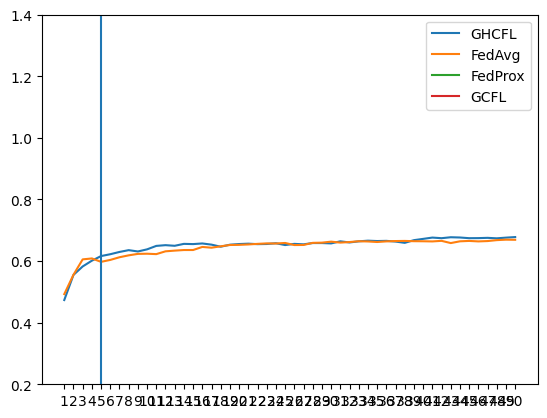

/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Nikkie/miniforge3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [37]:
clients=copy.deepcopy(init_clients)
server=copy.deepcopy(init_server)
fig, ax = plt.subplots()
# run_fedavg(clients, server, args.num_rounds, args.local_epoch, samp=None)
# run_fedprox(clients, server, args.num_rounds, args.local_epoch, mu = 0.01, samp=None)
# run_gcfl(clients, server, args.num_rounds, args.local_epoch, EPS_1, EPS_2)
run_ghcfl(clients, server, args.comm_threshold, args.dist_threshold, args.num_rounds, args.local_epoch)
# run_ghcfl_new(clients, server, args.comm_threshold, args.dist_threshold, args.num_rounds, args.local_epoch)
clients=copy.deepcopy(init_clients)
server=copy.deepcopy(init_server)
run_fedavg(clients, server, args.num_rounds, args.local_epoch, samp=None)
# clients=copy.deepcopy(init_clients)
# server=copy.deepcopy(init_server)
# run_fedprox(clients, server, args.num_rounds, args.local_epoch, mu = 0.01, samp=None)
ax.plot(mean_accs_ghcfl, label='GHCFL')
ax.plot(mean_accs_fedavg, label='FedAvg')
ax.plot(mean_accs_fedprox,label = 'FedProx')
ax.plot(mean_accs_gcfl,label = "GCFL")
plt.axvline(args.comm_threshold-1)
plt.ylim((0.2, 1.4))
plt.xticks(np.arange(len(mean_accs_ghcfl)), np.arange(1, len(mean_accs_ghcfl)+1))
plt.xticks(np.arange(len(mean_accs_fedavg)), np.arange(1, len(mean_accs_fedavg)+1))
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show() #图形可视化
    
mean_acc_fedavg = np.mean(mean_accs_fedavg)
mean_acc_fedprox = np.mean(mean_accs_fedprox)
mean_acc_gcfl = np.mean(mean_accs_gcfl)
mean_acc_ghcfl = np.mean(mean_accs_ghcfl)

In [38]:
print(mean_acc_fedavg)
print(mean_acc_fedprox)
print(mean_acc_gcfl)
print(mean_acc_ghcfl)
print(mean_acc_ghcfl/mean_acc_fedavg)

print(ratios)

print(last_acc_fedavg)
print(last_acc_fedprox)
print(last_acc_gcfl)
print(last_acc_ghcfl)

0.6440331939799293
nan
nan
0.6495783643229316
1.008610069162328
{'HCFL': 1, 'FedAvg': 4}
[]
[]
[]
[]


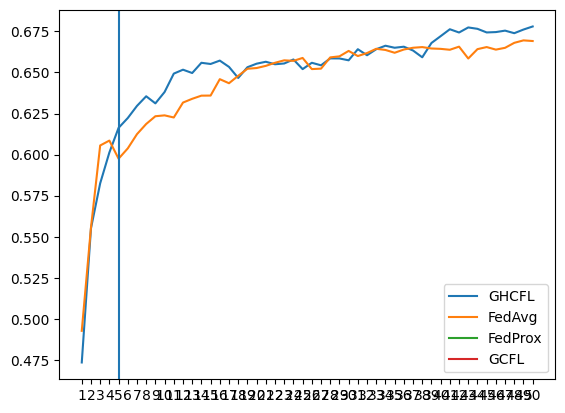

In [39]:
fig, ax1 = plt.subplots()
ax1.plot(mean_accs_ghcfl, label='GHCFL')
ax1.plot(mean_accs_fedavg, label='FedAvg')
ax1.plot(mean_accs_fedprox,label = 'FedProx')
ax1.plot(mean_accs_gcfl,label = "GCFL")
plt.axvline(args.comm_threshold-1)
# plt.ylim((0.2, 1.4))
plt.xticks(np.arange(len(mean_accs_ghcfl)), np.arange(1, len(mean_accs_ghcfl)+1))
plt.xticks(np.arange(len(mean_accs_fedavg)), np.arange(1, len(mean_accs_fedavg)+1))
ax1.legend() #自动检测要在图例中显示的元素，并且显示
plt.show() #图形可视化